In [94]:
# importing the libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from skimage import img_as_float
import cv2
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import denoise_tv_chambolle

In [152]:
# Load the image
img = cv2.imread('lenna.bmp', 0)
img_tv=img_as_float(img)

In [153]:
# Defining the functions for both the derivatives and their respective denoising fucntions

def rl_derivative(image, alpha, beta):
    """Calculate the fractional R-L derivative of an image"""
    kernel = np.array([1, -1])
    res = np.zeros(image.shape)
    for i in range(image.shape[0]):
        res[i,:] = signal.convolve(image[i,:], kernel, mode='same')
    for j in range(image.shape[1]):
        res[:,j] = signal.convolve(res[:,j], kernel, mode='same')
    return np.power(np.abs(res), alpha) * np.sign(res) * np.power(np.abs(res), beta)

def gl_derivative(image, alpha, beta, gamma):
    """Calculate the G-L fractional derivative of an image"""
    kernel = np.array([1, -1])
    res = np.zeros(image.shape)
    for i in range(image.shape[0]):
        res[i,:] = signal.convolve(image[i,:], kernel, mode='same')
    for j in range(image.shape[1]):
        res[:,j] = signal.convolve(res[:,j], kernel, mode='same')
    return np.power(np.abs(res), alpha) * np.sign(res) * np.power(np.abs(res), beta) * np.exp(-gamma*np.abs(res)**2)

def gl_denoise_image(image, alpha, beta, gamma, sigma):
    """Denoise an image using G-L fractional derivative"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    gl = gl_derivative(noisy_image, alpha, beta, gamma)
    denoised_image = image - gl
    return np.clip(denoised_image, 0, 255).astype(np.uint8)


def rl_denoise_image(image, alpha, beta, sigma):
    """Denoise an image using fractional R-L derivative"""
    noise = np.random.normal(0, sigma, image.shape)
    noisy_image = image + noise
    frl = rl_derivative(noisy_image, alpha, beta)
    denoised_image = image - frl
    return np.clip(denoised_image, 0, 255).astype(np.uint8)



In [157]:
# Denoising using the TV method

# Add Gaussian noise to the image
noisy_img_tv = img_tv + 0.1*np.random.randn(*img_tv.shape)
# Apply Total Variation (TV) denoising
denoised_img_tv = denoise_tv_chambolle(noisy_img_tv, weight=0.09)
# Calculate PSNR between the original and denoised images
psnr_tv = peak_signal_noise_ratio(img_tv, denoised_img_tv)

In [158]:
# Denoising the image using fractional approach

alpha = 0.5
beta = 0.5
gamma=0.01
sigma = 0
denoised_img_gl = gl_denoise_image(img, alpha, beta, gamma, sigma)
denoised_img_rl=rl_denoise_image(img, alpha, beta, sigma)
psnr_gl = peak_signal_noise_ratio(img, denoised_img_gl)
psnr_rl = peak_signal_noise_ratio(img, denoised_img_rl)

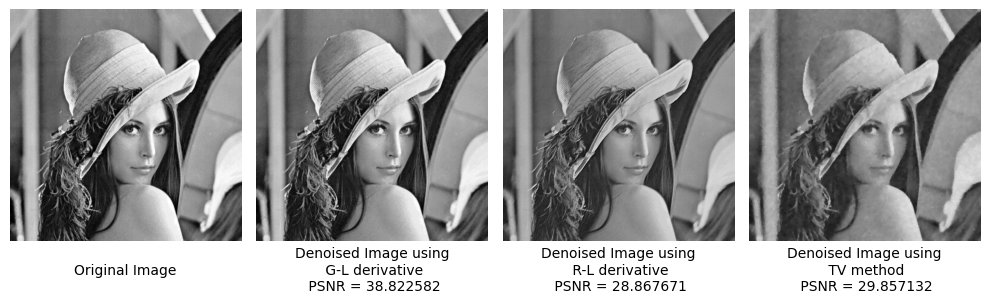

In [159]:
# plotting the results for comparison

fig, axes = plt.subplots(ncols=4, figsize=(10, 5))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title("Original Image", y=-0.18, fontsize=10)
ax[1].imshow(denoised_img_gl, cmap='gray')
ax[1].set_title("Denoised Image using\n G-L derivative\n PSNR = {:2f}".format(psnr_gl), y=-0.25, fontsize=10)
ax[2].imshow(denoised_img_rl, cmap='gray')
ax[2].set_title("Denoised Image using\n R-L derivative\n PSNR = {:2f}".format(psnr_rl), y=-0.25, fontsize=10)
ax[3].imshow(denoised_img_tv, cmap='gray')
ax[3].set_title("Denoised Image using\n TV method\n PSNR = {:2f}".format(psnr_tv), y=-0.25, fontsize=10)
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()